Predict demand by removing seasonality. This provides better accuracy than the naive prediction.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import os

PATH_CSV = '/content/drive/MyDrive/beach_demand_forecast/data'
 
df_sales_train = pd.read_csv(os.path.join(PATH_CSV,"sales_train.csv"))
df_items = pd.read_csv(os.path.join(PATH_CSV,"items.csv"))
df_resturant = pd.read_csv(os.path.join(PATH_CSV,"resturants.csv"))
df_person = pd.read_excel(os.path.join(PATH_CSV,"IMGpersonF(1).xlsx"))
df_sales_test = pd.read_csv(os.path.join(PATH_CSV,"sales_test.csv"))

df_sales_train.date = pd.to_datetime(df_sales_train.date, errors='coerce') 
df_sales_test.date = pd.to_datetime(df_sales_test.date, errors='coerce') 

Begin by producing a line graph of all sales over the provided 3-year timespan.

In [3]:
import plotly.express as px

df_plot = df_sales_train[['date','item_count']].groupby(['date']).mean().reset_index()
fig = px.line(df_plot, x="date", y="item_count", title='RAW Sales by Date')
fig.show()

## Detrending

Can you see an overall trend in this data? Beyond just the seasonality?

In [4]:
from scipy import signal

df_plot.item_count = signal.detrend(df_plot.item_count)

fig = px.line(df_plot, x="date", y="item_count", title='RAW Sales by Date')
fig.show()

In [5]:
from scipy import signal

df_plot.item_count = signal.detrend(df_plot.item_count)

fig = px.line(df_plot, x="date", y="item_count", title='RAW Sales by Date')
fig.show()

## De-Seasoning

Lets remove the seasonality.

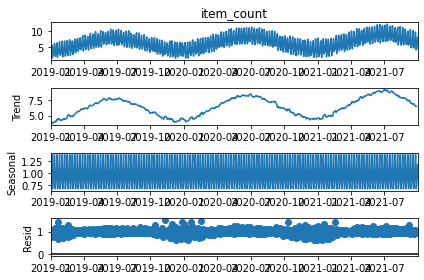

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot

df_plot = df_sales_train[['date','item_count']].groupby(['date']).mean() 

# extrapolate_trend='freq',
adjustment = seasonal_decompose(df_plot.item_count, model='multiplicative') # , model='additive', period=7

# multiplicative
# additive

adjustment.plot()
pyplot.show()

Notice how the yearly seasonality was detected as the trend? The weekly seasonality was detected as seasonal. Without zooming you cannot see the ups and downs of the individual days of the week.

In [7]:
adjustment.trend

date
2019-01-01         NaN
2019-01-02         NaN
2019-01-03         NaN
2019-01-04    3.920000
2019-01-05    3.672857
                ...   
2021-09-26    6.510000
2021-09-27    6.508571
2021-09-28         NaN
2021-09-29         NaN
2021-09-30         NaN
Name: trend, Length: 1004, dtype: float64

In [8]:
adjustment.seasonal

date
2019-01-01    0.793866
2019-01-02    0.889800
2019-01-03    1.177428
2019-01-04    1.378462
2019-01-05    1.380887
                ...   
2021-09-26    0.675276
2021-09-27    0.704281
2021-09-28    0.793866
2021-09-29    0.889800
2021-09-30    1.177428
Name: seasonal, Length: 1004, dtype: float64

## Resulting Dataset
Lets see the dataset "flattened".

In [9]:
df_plot2 = df_plot.copy()

df_plot2.item_count = df_plot2.item_count / adjustment.seasonal / adjustment.trend

fig = px.line(df_plot2.reset_index(), x="date", y="item_count", title='RAW Sales by Date')
fig.show()

In [10]:
df_adjustment = pd.DataFrame(adjustment.seasonal)
df_adjustment['trend'] = adjustment.trend

df_adjustment

,seasonal,trend
date,,
2019-01-01,0.793866,NaN
2019-01-02,0.889800,NaN
2019-01-03,1.177428,NaN
2019-01-04,1.378462,3.920000
2019-01-05,1.380887,3.672857
...,...,...
2021-09-26,0.675276,6.510000
2021-09-27,0.704281,6.508571
2021-09-28,0.793866,NaN


We will save the adjustment table to a binary pickle form, so we can later reload it exactly as it is. We will make use of this table during day 2.

In [11]:
df_adjustment.to_pickle("adjustment.pkl")

### Convert All Items
Now that we've estimated seasonality and trend for the average of all items, we must apply this to the individual items.

In [12]:
df_sales_adj = df_sales_train.merge(df_adjustment,right_index=True,left_on="date")
df_sales_adj.dropna(inplace=True)
df_sales_adj['adjust'] = df_sales_adj.item_count / df_sales_adj.seasonal / df_sales_adj.trend

Compare the individual item plot to the previous example with seasonality still embeded.

In [13]:
SINGLE_YEAR = 2020

df_sales_single_year = df_sales_adj[df_sales_train['date'].dt.year == SINGLE_YEAR]
df_plot = df_sales_single_year[['date','item_id','adjust']].groupby(['date','item_id']).mean().reset_index()
df_plot = df_plot.merge(df_items,left_on="item_id",right_on="id")[['date','adjust','name']]
fig = px.bar(df_plot, x='date', y='adjust',color="name", title=f'Item Sales by Date - {SINGLE_YEAR}')
fig.update_layout(bargap=0.0,bargroupgap=0.0)
fig.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



## Model with Adjusted Data
Now lets model, with this mostly cleaned up data.

Utility function to create sequences.

In [14]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

We will link the season and trend adjustments.

In [15]:
df_items2 = df_items[['id','store_id']]
df_train = df_sales_adj.merge(df_items2,left_on='item_id',right_on='id')
df_train[['date','item_id','adjust','store_id','item_count','seasonal','trend']]

df_train = df_train.sort_values('date').groupby(['item_id', 'store_id', 'date'], as_index=False)
df_train = df_train.agg({'adjust':['mean'],'item_count':['mean'],'seasonal':['mean'],'trend':['mean']})
df_train.columns = ['item', 'store', 'date', 'adjust', 'item_count', 'seasonal', 'trend']
df_train.head()

,item,store,date,adjust,item_count,seasonal,trend
0,1,4,2019-01-04,0.0,0.0,1.378462,3.920000
1,1,4,2019-01-05,0.0,0.0,1.380887,3.672857
2,1,4,2019-01-06,0.0,0.0,0.675276,3.685714
3,1,4,2019-01-07,0.0,0.0,0.704281,3.695714
4,1,4,2019-01-08,0.0,0.0,0.793866,3.722857


Lets also engineer two features. This gives the neural network some information about what day of the week and day of the year we are in. Ideally, these are not needed with seasonality generally removed; however, if some seasonality and trend remain, maybe these two features help the neural network to overcome.

In [16]:
df_train['dow'] = df_train['date'].dt.dayofweek
df_train['doy'] = df_train['date'].dt.dayofyear
df_train

,item,store,date,adjust,item_count,seasonal,trend,dow,doy
0,1,4,2019-01-04,0.0,0.0,1.378462,3.920000,4,4
1,1,4,2019-01-05,0.0,0.0,1.380887,3.672857,5,5
2,1,4,2019-01-06,0.0,0.0,0.675276,3.685714,6,6
3,1,4,2019-01-07,0.0,0.0,0.704281,3.695714,0,7
4,1,4,2019-01-08,0.0,0.0,0.793866,3.722857,1,8
...,...,...,...,...,...,...,...,...,...
99795,100,2,2021-09-23,0.0,0.0,1.177428,6.645714,3,266
99796,100,2,2021-09-24,0.0,0.0,1.378462,6.555714,4,267
99797,100,2,2021-09-25,0.0,0.0,1.380887,6.507143,5,268
99798,100,2,2021-09-26,0.0,0.0,0.675276,6.510000,6,269


Build the sequence data.

In [17]:
window = 29
future_span = 30
series = series_to_supervised(df_train.drop('date', axis=1), window=window, lag=future_span)
series.head()

,item(t-29),store(t-29),adjust(t-29),item_count(t-29),seasonal(t-29),trend(t-29),dow(t-29),doy(t-29),item(t-28),store(t-28),...,dow(t),doy(t),item(t+30),store(t+30),adjust(t+30),item_count(t+30),seasonal(t+30),trend(t+30),dow(t+30),doy(t+30)
29,1.0,4.0,0.0,0.0,1.378462,3.920000,4.0,4.0,1.0,4.0,...,5,33,1.0,4.0,0.0,0.0,0.704281,4.892857,0.0,63.0
30,1.0,4.0,0.0,0.0,1.380887,3.672857,5.0,5.0,1.0,4.0,...,6,34,1.0,4.0,0.0,0.0,0.793866,4.971429,1.0,64.0
31,1.0,4.0,0.0,0.0,0.675276,3.685714,6.0,6.0,1.0,4.0,...,0,35,1.0,4.0,0.0,0.0,0.889800,5.044286,2.0,65.0
32,1.0,4.0,0.0,0.0,0.704281,3.695714,0.0,7.0,1.0,4.0,...,1,36,1.0,4.0,0.0,0.0,1.177428,5.117143,3.0,66.0
33,1.0,4.0,0.0,0.0,0.793866,3.722857,1.0,8.0,1.0,4.0,...,2,37,1.0,4.0,0.0,0.0,1.378462,5.184286,4.0,67.0


Remove sequences that did not have enough data.

In [18]:
# Remove edge cases, where there were not enough values to complete a series
last_item = 'item(t-%d)' % window
last_store = 'store(t-%d)' % window
last_dow = 'dow(t-%d)' % window
last_doy = 'doy(t-%d)' % window
series = series[(series['store(t)'] == series[last_store])]
series = series[(series['item(t)'] == series[last_item])]

We will predict with adjusted sales, and our engineered features.

In [19]:
import numpy as np
from keras.utils.np_utils import to_categorical   

def drop_column(df, col):
  columns_to_drop = [('%s(t+%d)' % (col, future_span))]
  for i in range(window, 0, -1):
      columns_to_drop += [('%s(t-%d)' % (col, i))]
  df.drop(columns_to_drop, axis=1, inplace=True, errors='ignore')
  df.drop([f"{col}(t)"], axis=1, inplace=True, errors='ignore')

def cat_seq(df, col):
  return to_categorical(df[col].values)

# Label
labels_col = 'adjust(t+%d)' % future_span
labels = series[labels_col]
series.drop(labels_col, axis=1, inplace=True)
series.drop('item(t+%d)' % future_span, axis=1, inplace=True)
series.drop('store(t+%d)' % future_span, axis=1, inplace=True)
series.drop('dow(t+%d)' % future_span, axis=1, inplace=True)
series.drop('doy(t+%d)' % future_span, axis=1, inplace=True)

# Adjustment columns
unadjust_sales_col = 'item_count(t+%d)' % future_span
seasonal_col = 'seasonal(t+%d)' % future_span
trend_col = 'trend(t+%d)' % future_span

hold_sales = series[unadjust_sales_col]
hold_seasonal = series[seasonal_col]
hold_trend = series[trend_col]

series.drop(unadjust_sales_col, axis=1, inplace=True)
series.drop(seasonal_col, axis=1, inplace=True)
series.drop(trend_col, axis=1, inplace=True)


# Get sales sequences
series2 = series.copy()
drop_column(series2, "item")
drop_column(series2, "store")
drop_column(series2, "dow")
drop_column(series2, "doy")
sales_series = series2.values

# Day of week as a categorical
series2 = series.copy()
drop_column(series2, "item")
drop_column(series2, "store")
drop_column(series2, "doy")
drop_column(series2, "adjust")
dow_series = series2.values

# Get item sequences
series2 = series.copy()
drop_column(series2, "item")
drop_column(series2, "store")
drop_column(series2, "dow")
drop_column(series2, "adjust")
doy_series = series2.values

# Day of year
t1 = sales_series.reshape(sales_series.shape + (1,))
t2 = dow_series.reshape(dow_series.shape + (1,)) 
t3 = doy_series.reshape(doy_series.shape + (1,))
x = np.concatenate([t1,t2,t3],axis=2)

Double check that all input data is of the same shape.

In [20]:
print(t1.shape)
print(t2.shape)
print(t3.shape)

(96870, 120, 1)
(96870, 120, 1)
(96870, 120, 1)


Extract the predictors (x sequences) and the label (future prediction)

In [21]:
from sklearn.model_selection import train_test_split

# Split the training data into training and validation
data = np.arange(len(x))
y = labels.values
np.random.shuffle(data)
split_pt = int(len(data) * 0.2)
x_valid = x[data[:split_pt]]
x_train = x[data[split_pt:]]
y_valid = y[data[:split_pt]]
y_train = y[data[split_pt:]]

# Also split the seasonality/trend data
y_train_actual = hold_sales.iloc[data[split_pt:]]
y_valid_actual = hold_sales.iloc[data[:split_pt]]

y_train_seasonal = hold_seasonal.iloc[data[split_pt:]]
y_valid_seasonal = hold_seasonal.iloc[data[:split_pt]]

y_train_trend = hold_trend.iloc[data[split_pt:]]
y_valid_trend = hold_trend.iloc[data[:split_pt]]

# Display results
print('Train set shape', x_train.shape)
print('Validation set shape', x_valid.shape)

Train set shape (77496, 120, 3)
Validation set shape (19374, 120, 3)


Final preparation for the x and y.

In [22]:
print('Train set shape', x_train.shape)
print('Validation set shape', y_valid.shape)

Train set shape (77496, 120, 3)
Validation set shape (19374,)


Construct the neural network.

In [26]:
import tensorflow as tf 
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D, LSTM
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Dropout
import keras

epochs = 500
batch = 256
lr = 0.0003
adam = tf.keras.optimizers.Adam(lr)

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=8, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(50,dropout=0.2,return_sequences=True))
model.add(LSTM(50))
model.add(Flatten())
model.add(Dense(1))
model.compile(loss='mse', optimizer=adam)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 113, 64)           1600      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 56, 64)           0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 56, 50)            23000     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 flatten (Flatten)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                      

Fit the neural network.

In [27]:
from keras.callbacks import EarlyStopping

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, 
        verbose=1, mode='auto', restore_best_weights=True)

cnn_history = model.fit(x_train, y_train, callbacks=[monitor],
    validation_data=(x_valid, y_valid), epochs=epochs, verbose=2)

Epoch 1/500
2422/2422 - 100s - loss: 7.5121 - val_loss: 4.7541 - 100s/epoch - 41ms/step
Epoch 2/500
2422/2422 - 95s - loss: 3.2486 - val_loss: 2.5589 - 95s/epoch - 39ms/step
Epoch 3/500
2422/2422 - 94s - loss: 2.5848 - val_loss: 2.4230 - 94s/epoch - 39ms/step
Epoch 4/500
2422/2422 - 94s - loss: 2.4088 - val_loss: 2.2855 - 94s/epoch - 39ms/step
Epoch 5/500
2422/2422 - 102s - loss: 2.4028 - val_loss: 3.5511 - 102s/epoch - 42ms/step
Epoch 6/500
2422/2422 - 100s - loss: 2.3962 - val_loss: 2.2757 - 100s/epoch - 41ms/step
Epoch 7/500
2422/2422 - 98s - loss: 2.2740 - val_loss: 2.3589 - 98s/epoch - 40ms/step
Epoch 8/500
2422/2422 - 98s - loss: 2.2797 - val_loss: 2.3089 - 98s/epoch - 40ms/step
Epoch 9/500
2422/2422 - 98s - loss: 2.2551 - val_loss: 2.3367 - 98s/epoch - 40ms/step
Epoch 10/500
2422/2422 - 100s - loss: 2.2525 - val_loss: 2.3464 - 100s/epoch - 41ms/step
Epoch 11/500
2422/2422 - 98s - loss: 2.2760 - val_loss: 2.2455 - 98s/epoch - 41ms/step
Epoch 12/500
2422/2422 - 99s - loss: 2.2326 

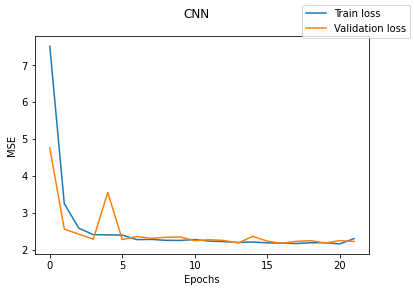

In [28]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(cnn_history.history['loss'], label='Train loss')
plt.plot(cnn_history.history['val_loss'], label='Validation loss')
fig.legend()
fig.suptitle('CNN')
plt.xlabel("Epochs")
plt.ylabel("MSE")

plt.show()

In [29]:
from sklearn.metrics import mean_squared_error 
import numpy as np

cnn_train_pred = model.predict(x_train) 
cnn_valid_pred = model.predict(x_valid) 
print('Train rmse:', np.sqrt(mean_squared_error(y_train, cnn_train_pred))) 
print('Validation rmse:', np.sqrt(mean_squared_error(y_valid, cnn_valid_pred)))

606/606 [==============================] - 7s 11ms/step
Train rmse: 1.4670568963090518
Validation rmse: 1.474365105719529


In [30]:
cnn_train_pred2 = cnn_train_pred.flatten() * y_train_seasonal * y_train_trend
cnn_valid_pred2 = cnn_valid_pred.flatten() * y_valid_seasonal * y_valid_trend

print('Train rmse:', np.sqrt(mean_squared_error(y_train_actual, cnn_train_pred2)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_valid_actual, cnn_valid_pred2)))

Train rmse: 9.102332563143108
Validation rmse: 8.752350079950682
